## Blob Method 
This notebook works inside a QuaKe/examples folder.
- Finding the hits corresponding to the track endpoints (blob centres) with a BFS (Breadth First Search) method.
- Collecting the blob energies within a radius r
- The most energetic blob is labeled as blob1, the other as blob2, with energies respectively en_1 and e_2
- en_1 and e_2 are treated as input features for SVM, which makes a prediction (Neyman-Pearson lemma could be applied instead).

In [1]:
from quake.models.attention.attention_dataloading import read_data
from quake.models.cnn.cnn_dataloading import read_data as read_data_CNN
from quake.utils.utils import load_runcard
from pathlib import Path
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

2022-12-10 14:23:54.640746: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_folder = Path("../../output_50_10/data") # dataset with [1x1x1]mm^3 resolution @ 50keV threshold
train_folder = Path("../../output_50_10/models/attention")
setup = load_runcard(data_folder.parent/ "cards/runcard.yaml")
setup["seed"] = 42 # may be set as we please

In [3]:
binwidths = np.array(setup["detector"]["resolution"])

In [4]:
train_generator, val_generator, test_generator = read_data(data_folder, train_folder, setup)

[INFO] (quake.attention) Saving splitting maps in folder ../../output_50_10/models/attention
[INFO] (quake.attention) Train dataset balancing: 14686 training points, of which 47.48% positives
[INFO] (quake.attention) Validation dataset balancing: 3147 training points, of which 48.01% positives
[INFO] (quake.attention) Test dataset balancing: 3147 training points, of which 48.14% positives


In [5]:
def distance(sample, i, j, euclid = True):
    if euclid:
        pi = sample[i, :3]
        pj = sample[j, :3]
    else:
        pi = sample[i, :3]/binwidths
        pj = sample[j, :3]/binwidths
    return np.sqrt(np.sum((pi - pj)**2))

def adjacency_matrix(sample):
    n = sample.shape[0]
    d = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i != j and distance(sample, i, j, euclid = False) <= np.sqrt(3):
                d[i,j] = 1
    return d

def distance_matrix(sample):
    n = sample.shape[0]
    d = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            d[i,j] = distance(sample, i, j, euclid = True)
    return d
def find_main_trajectory(G):
    n = G.number_of_nodes()
    max = 0
    p1 = -1
    p2 = -1
    for i in range(n):
        for j in range(n):
            try:
                m = nx.shortest_path_length(G, source = i, target = j)
            except:
                m = -1
            if m > max:
                max = m
                p1 = i
                p2 = j
    return max, p1, p2

In [6]:
def get_blob_energies(point_clouds):
    n = point_clouds.shape[0]
    en_1 = np.zeros(n)
    en_2 = np.zeros(n)
    r = 2 #mm - blob radius
    for i in range(n):
        sample = point_clouds[i]
        adj = adjacency_matrix(sample)
        d = distance_matrix(sample)
        G = nx.from_numpy_matrix(adj) # Graphs can be visualized with nx.draw(G, with_labels = True)
        len, blob1, blob2 = find_main_trajectory(G)
        en_blob_1 = np.sum(sample[d[blob1] < r, -1])
        en_blob_2 = np.sum(sample[d[blob2] < r, -1])
        if en_blob_1 > en_blob_2:
            en_1[i] = en_blob_1
            en_2[i] = en_blob_2
        else:
            en_1[i] = en_blob_2
            en_2[i] = en_blob_1
    return en_1, en_2

In [7]:
# Extracting blob energies from point-cloud trackss
training_en_1, training_en_2 = get_blob_energies(train_generator.inputs)
val_en_1, val_en_2 = get_blob_energies(val_generator.inputs)
test_en_1, test_en_2 = get_blob_energies(test_generator.inputs)

In [15]:
# Labels
training_labels = train_generator.targets
val_labels = val_generator.targets
test_labels = test_generator.targets

As expected, bb events have blobs with similar energyes, and datapoints arrange closer to the bisector. For b events, only one is a proper blob (marking the single-electron stopping-point position), hence one blob candidate has more energy than the other one.

Text(0, 0.5, 'Blob energy 2')

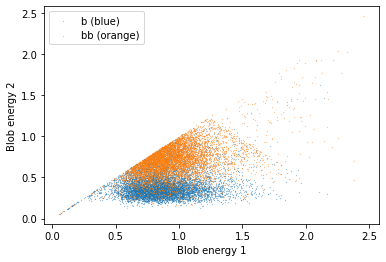

In [16]:
plt.scatter(training_en_1[training_labels == 0], training_en_2[training_labels == 0], s = 0.03)
plt.scatter(training_en_1[training_labels == 1], training_en_2[training_labels == 1], s = 0.03)
plt.legend(["b (blue)", "bb (orange)"])
plt.xlabel("Blob energy 1")
plt.ylabel("Blob energy 2")

In [17]:
# Training a SVM for classification
from sklearn.svm import SVC
training_data = np.vstack([training_en_1, training_en_2]).T
val_data = np.vstack([val_en_1, val_en_2]).T
clf = SVC(C = 1)
clf.fit(training_data, training_labels)

SVC(C=1)

In [18]:
# Performance evaluation
print("accuracy on training: ", clf.score(training_data, training_labels))
print("accuracy on validation: ", clf.score(val_data, val_labels))

accuracy on training:  0.8429797085659813
accuracy on validation:  0.8592310136638068


In [19]:
# Adding number of hits features
train_nhits = train_generator.get_extra_features()[:,0]
val_nhits = val_generator.get_extra_features()[:,0]

training_data = np.hstack([training_data, np.reshape(train_nhits, [-1,1])])
val_data = np.hstack([val_data, np.reshape(val_nhits, [-1,1])])

clf = SVC(C = 1)
clf.fit(training_data, training_labels)
print("accuracy on training: ", clf.score(training_data, training_labels))
print("accuracy on validation: ", clf.score(val_data, val_labels))

accuracy on training:  0.840051749965954
accuracy on validation:  0.855735621226565


In [20]:
hist_b = np.histogram2d(training_en_1[training_labels == 0], training_en_2[training_labels == 0], bins = (70,70), range = [[0, 2.5],[0, 2.5]])
hist_bb = np.histogram2d(training_en_1[training_labels == 1], training_en_2[training_labels == 1], bins = (70,70), range = [[0, 2.5],[0, 2.5]])
pdf_b = hist_b[0]/hist_b[0].sum() + 1e-13
pdf_bb = hist_bb[0]/hist_bb[0].sum() + 1e-13
grid_idx_1 = ((training_en_1/2.5 * 70) ).astype(int)
grid_idx_2 = ((training_en_2/2.5 * 70) ).astype(int)

In [21]:
def neyman_pearson(pdfb, pdfbb, idx1, idx2):
    return np.log(pdfb[idx1, idx2]) /  np.log(pdfbb[idx1, idx2])

In [22]:
q = neyman_pearson(pdf_b, pdf_bb, grid_idx_1, grid_idx_2)
q = q/q.max()

(array([   0.,    0.,    0.,    0.,    0.,   11.,  166.,  218.,  275.,
         291.,  553.,  531., 1240., 1203.,  971.,  746.,  198.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,  137.,    0.,    0.,
          50.,    0.,   60.,   80.,   40.,   66.,   28.,    0.,    0.,
          22.,   25.,   14.,   16.,   36.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

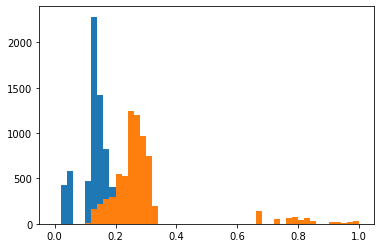

In [23]:
plt.hist(q[training_labels == 0], bins = 50, range = [0, 1])
plt.hist(q[training_labels == 1], bins = 50, range = [0, 1])

In [24]:
span = np.linspace(0, 1, 50)
accuracy = np.zeros(50)
for i, c in enumerate(span):
    prediction = q > c
    accuracy[i] = np.sum(training_labels == prediction) / len(q)
print("accuracy is", accuracy.max(), "when selecting q >", np.argmax(accuracy)/50)

accuracy is 0.845771483045077 when selecting q > 0.2


In [39]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow import convert_to_tensor

def convblocks(input_layer, iterations, alpha, dropout_rate):
    """
    Returns sequences of convolutional-activation-dropout layers blocks

    Parameters
    ----------
        - input_layer: first layer of the Neural Network
        - iterations: number of blocks
        - alpha: ReLU leakage parameter
        - dropout_rate: dropout strength
    """
    conv = list()
    leaky = list()
    drop = list()

    for i in range(0, iterations):
        if i == 0:
            conv.append(Conv2D(25, kernel_size=(3, 3))(input_layer))
        else:
            conv.append(Conv2D(25, kernel_size=(3, 3))(drop[i - 1]))
        leaky.append(LeakyReLU(alpha=alpha)(conv[i]))
        drop.append(Dropout(dropout_rate)(leaky[i]))
    return drop[-1]

In [46]:
input1 = Input((20,20, 1))
input2 = Input((20,20, 1))
input3 = Input((20,20, 1))
input4 = Input((2))
alpha = 0.05
dropout_rate = 0.15
lr = 0.001

d1 = convblocks(input1, 2, alpha, dropout_rate)
d2 = convblocks(input2, 2, alpha, dropout_rate)
d3 = convblocks(input3, 2, alpha, dropout_rate)
feature_number = 2

f1 = Flatten()(d1)
f2 = Flatten()(d2)
f3 = Flatten()(d3)

concat_layer = Concatenate()([f1, f2, f3])

dense1 = Dense(10)(concat_layer)
relu1 = LeakyReLU(alpha=alpha)(dense1)

physics_layer = Concatenate()([relu1, input4])

# dense2 = Dense(10)(physics_layer)
# relu2 = LeakyReLU(alpha = alpha)(dense2)

pred = Dense(1, activation="sigmoid")(physics_layer)

model = Model(inputs=[input1, input2, input3, input4], outputs=pred)
model.compile(
    loss=BinaryCrossentropy(), optimizer=Adam(lr), metrics=["accuracy"]
)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 20, 20, 1)]  0           []                               
                                                                                                  
 input_37 (InputLayer)          [(None, 20, 20, 1)]  0           []                               
                                                                                                  
 input_38 (InputLayer)          [(None, 20, 20, 1)]  0           []                               
                                                                                                  
 conv2d_54 (Conv2D)             (None, 18, 18, 25)   250         ['input_36[0][0]']               
                                                                                            

In [27]:
train_generator_cnn, val_generator_cnn, test_generator_cnn = read_data_CNN(data_folder, train_folder, setup)

[INFO] (quake.cnn) Loading../../output_50_10/data/e_4283.root.npz
[INFO] (quake.cnn) Loading../../output_50_10/data/bb_13659.root.npz
[INFO] (quake.cnn) Loading../../output_50_10/data/bb_13746.root.npz
[INFO] (quake.cnn) Loading../../output_50_10/data/e_23517.root.npz
[INFO] (quake.cnn) Loading../../output_50_10/data/bb_11771.root.npz
[INFO] (quake.cnn) Loading../../output_50_10/data/e_26190.root.npz
[INFO] (quake.cnn) Loading../../output_50_10/data/bb_12227.root.npz
[INFO] (quake.cnn) Loading../../output_50_10/data/e_25714.root.npz
[INFO] (quake.cnn) Loading../../output_50_10/data/bb_12006.root.npz
[INFO] (quake.cnn) Loading../../output_50_10/data/e_645.root.npz
[INFO] (quake.cnn) Loading../../output_50_10/data/e_15844.root.npz
[INFO] (quake.cnn) Loading../../output_50_10/data/bb_13247.root.npz
[INFO] (quake.cnn) Loading../../output_50_10/data/e_8702.root.npz
[INFO] (quake.cnn) Loading../../output_50_10/data/bb_12603.root.npz
[INFO] (quake.cnn) Loading../../output_50_10/data/bb_13111.

In [28]:
train_xy = train_generator_cnn.xy_planes
val_xy = val_generator_cnn.xy_planes
train_xz = train_generator_cnn.xz_planes
val_xz = val_generator_cnn.xz_planes
train_yz = train_generator_cnn.yz_planes
val_yz = val_generator_cnn.yz_planes

In [47]:
batch_size = 120
epochs = 50
model.fit(
    [train_xy, train_xz, train_yz, training_data[:,:2]/10],
    training_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([val_xy, val_xz, val_yz, val_data[:,:2]/10], val_labels),
    verbose=1,
    shuffle = True
)

Epoch 1/50
123/123 [==============================] - 25s 194ms/step - loss: 0.6458 - accuracy: 0.6272 - val_loss: 0.6100 - val_accuracy: 0.6692
Epoch 2/50
123/123 [==============================] - 24s 191ms/step - loss: 0.6142 - accuracy: 0.6606 - val_loss: 0.5976 - val_accuracy: 0.6841
Epoch 3/50
123/123 [==============================] - 24s 194ms/step - loss: 0.5935 - accuracy: 0.6864 - val_loss: 0.5746 - val_accuracy: 0.7038
Epoch 4/50
123/123 [==============================] - 24s 194ms/step - loss: 0.5782 - accuracy: 0.7039 - val_loss: 0.5587 - val_accuracy: 0.7159
Epoch 5/50
123/123 [==============================] - 24s 193ms/step - loss: 0.5618 - accuracy: 0.7169 - val_loss: 0.5430 - val_accuracy: 0.7394
Epoch 6/50
123/123 [==============================] - 24s 199ms/step - loss: 0.5499 - accuracy: 0.7271 - val_loss: 0.5363 - val_accuracy: 0.7413
Epoch 7/50
123/123 [==============================] - 24s 194ms/step - loss: 0.5411 - accuracy: 0.7321 - val_loss: 0.5254 - val_ac